In [1]:
import datetime as dt
import pickle
import random
import tqdm

In [2]:
from creme import compose
from creme import feature_extraction
from creme import linear_model
from creme import metrics
from creme import optim
from creme import preprocessing
from creme import stats
from creme import stream

Get informations on dates:

In [3]:
def extract_date(x):
    if not isinstance(x['date'], dt.datetime):
        x['date'] = dt.datetime.strptime(x['date'], '%Y-%m-%d')
    x['month'] = x['date'].month
    x['wday'] = x['date'].weekday()
    return x

Get metadata of the product: cat_id, dept_id, item_id, state_id and store id.

In [4]:
def get_metadata(x):
    key = x['id'].split('_')
    x['cat_id'] = f'{key[0]}'
    x['dept_id'] = f'{x["cat_id"]}_{key[1]}'
    x['item_id'] = f'{x["cat_id"]}_{x["dept_id"]}_{key[2]}'
    x['state_id'] = f'{key[3]}'
    x['store_id'] = f'{x["state_id"]}_{key[4]}'
    return x 

#### Pipeline Construction

The ``compose.Select`` method is used to select the features that will be used to train our model.

In [5]:
feature_selection = compose.Select('wday', 'month', 'sell_price', 'snap_CA', 'snap_TX', 'snap_WI')

In addition to the features we have selected, we will build aggregates KPIs such as target encoding or grouped average to improve the performance of the model.

In [6]:
extract_features = compose.TransformerUnion([
    feature_selection,
    # Feature based on sell_price.
    feature_extraction.Agg('sell_price', 'store_id', how=stats.Mean()),
    feature_extraction.Agg('sell_price', 'item_id', how=stats.Mean()),
    feature_extraction.Agg('sell_price', ['store_id', 'item_id'], how=stats.Mean()),
    # Target encoding based on item, and dates.
    feature_extraction.TargetAgg(by='item_id', how=stats.BayesianMean(prior=0, prior_weight=1)),
    feature_extraction.TargetAgg(by=['wday', 'item_id'], how=stats.BayesianMean(prior=0, prior_weight=1)),
    feature_extraction.TargetAgg(by=['month', 'item_id'], how=stats.BayesianMean(prior=0, prior_weight=1)),
    # Target encoding based on store.
    feature_extraction.TargetAgg(by=['store_id', 'item_id'], how=stats.BayesianMean(prior=0, prior_weight=1)),
    feature_extraction.TargetAgg(by=['store_id', 'cat_id'], how=stats.BayesianMean(prior=0, prior_weight=1)),
    feature_extraction.TargetAgg(by=['store_id', 'wday', 'item_id'], how=stats.BayesianMean(prior=0, prior_weight=1)),
    # Target encoding based on event_name, event_type and store_id.
    feature_extraction.TargetAgg(by=['store_id', 'event_name_1'], how=stats.BayesianMean(prior=0, prior_weight=1)),
    feature_extraction.TargetAgg(by=['store_id', 'event_name_2'], how=stats.BayesianMean(prior=0, prior_weight=1)),
    feature_extraction.TargetAgg(by=['store_id', 'event_type_1'], how=stats.BayesianMean(prior=0, prior_weight=1)),
    feature_extraction.TargetAgg(by=['store_id', 'event_type_2'], how=stats.BayesianMean(prior=0, prior_weight=1)),
    # Target encoding based on item_id, and event_name.
    feature_extraction.TargetAgg(by=['item_id', 'event_name_1'], how=stats.BayesianMean(prior=0, prior_weight=1)),
    feature_extraction.TargetAgg(by=['item_id', 'event_name_2'], how=stats.BayesianMean(prior=0, prior_weight=1)),
])

The pipeline we define is composed of:

- A function that extracts ```metadata``` related to the item.
- Function that extracts ```the month``` and ```the day number, ie {'Monday': 1, 'Tuesday': 2}```. 
- Function that extracts the ```features based on the targets we are trying to predict and on the price of items```.
- ```Standard scaler``` to center reduce features before updating the model.
- ```Linear regression``` using ```stocastic gradient descent``` as an optimizer. 

In [7]:
model = (
    compose.FuncTransformer(get_metadata) |
    compose.FuncTransformer(extract_date) |
    extract_features |
    preprocessing.StandardScaler() |
    linear_model.LinearRegression(
        intercept=0,
        optimizer=optim.SGD(0.00001),
        intercept_lr=0.0005
    )
)

In [8]:
random.seed(42)

params = dict(
    target_name='y', 
    converters={
        'y': int, 
        'sell_price': float, 
        'snap_WI': int, 
        'snap_TX': int, 
        'snap_CA': int,
        'date': str
    }
)

X_y = stream.iter_csv('./data/train.csv', **params)

bar = tqdm.tqdm(X_y, position = 0)

metric = metrics.Rolling(metrics.MAE(), 100000)

for i, (x, y) in enumerate(bar):
    
    # First predict, we are doing progressive validation.
    y_pred = model.predict_one(x)
    
    # Update the model.
    model.fit_one(x=x, y=y)
    
    # Update the metric.
    metric = metric.update(y, y_pred)
    
    # Update tqdm progress bar every j iterations.
    if i % 2000 == 0:
        
        bar.set_description(f'MAE: {metric.get():4f}')

MAE: 1.239494: : 58254194it [10:23:14, 1557.84it/s]


In [11]:
with open(f'./models/linear_regression.pickle', 'wb') as f: 
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL) 

Our pipeline:

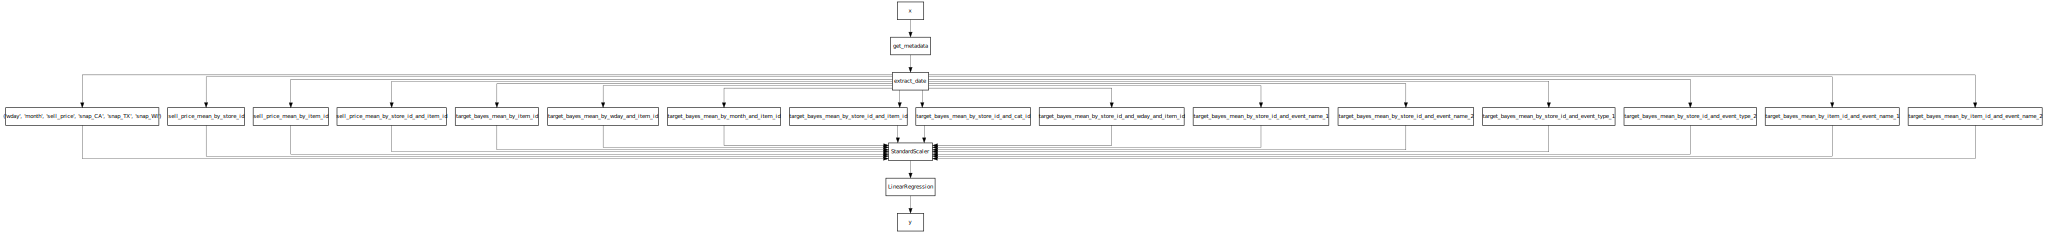

In [10]:
model.draw()

#### Now that we have defined our pipeline and our model is pre-trained, we will be able to move into production. I will use the Chantilly library to deploy the model in production.